# Adversarial Variational Bayes

In [1]:
%matplotlib inline

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import pickle
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
# Get MNIST dataset
mnist = input_data.read_data_sets('data', one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [3]:
# Create the model
class AVB():    
    def __init__(self, io_size, z_dim, eps_dim, hidden_size, build=True):
        # sizes
        self.io_size = io_size
        self.z_dim = z_dim
        self.eps_dim = eps_dim
        self.hidden_size = hidden_size
        self.smooth = 0.9
        
        # graph config
        self.gc = dict()
        
        if build:
            self.build()
            # Save names
            self.set_gc_names()            
            
    def placeholders(self):
        self.input = tf.placeholder(tf.float32, shape=[None, self.io_size], name='input')
        self.eps = tf.placeholder(tf.float32, shape=[None, self.eps_dim], name='eps_input')
        self.z_input = tf.placeholder(tf.float32, shape=[None, self.z_dim], name='z_input')
        
    def encoder(self, X, eps, reuse=False):
        with tf.variable_scope('encoder', reuse=reuse):
            # Encoder layers
            X_ = tf.contrib.layers.flatten(X)
            layer = tf.concat([X_, eps], axis=1)
            layer = tf.contrib.layers.fully_connected(layer, self.hidden_size, activation_fn=tf.nn.relu)
            z = tf.contrib.layers.fully_connected(layer, self.z_dim, activation_fn=None)
            
            return z
            
    def decoder(self, z, reuse=False): 
        with tf.variable_scope('decoder', reuse=reuse):
            # Decoder layers
            layer = tf.contrib.layers.fully_connected(z, self.hidden_size, activation_fn=tf.nn.relu)        
            logits = tf.contrib.layers.fully_connected(layer, self.io_size, activation_fn=None)
            out = tf.nn.sigmoid(logits)
            
            return out, logits
        
    def discriminator(self, X, z, reuse=False):
        with tf.variable_scope('discriminator', reuse=reuse):
            X_ = tf.contrib.layers.flatten(X)
            layer = tf.concat([X_, z], axis=1)
            #d_hidden_dim = int(tf.shape(layer)[1]//2)
            d_hidden_dim = int(layer.get_shape().as_list()[1]//2) #int(tf.shape(layer)[1]//2)
            layer = tf.contrib.layers.fully_connected(layer, d_hidden_dim, activation_fn=tf.nn.relu)
            logit = tf.contrib.layers.fully_connected(layer, 1, activation_fn=None)
            
            return logit
            
    def build(self):
        self.placeholders()
        
        z = self.encoder(self.input, self.eps)
        self.reconstituted, logits = self.decoder(z)
        self.samples, _ = self.decoder(self.z_input, reuse=True)
        dfake_logit = self.discriminator(self.input, z)
        dreal_logit = self.discriminator(self.input, self.z_input, reuse=True)
        
        # Trainable variables
        enc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='encoder')
        dec_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='decoder')
        disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
        
        ## Loss functions
        # Reconstruction loss
        recon = tf.reduce_sum(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=self.input), 
                        axis=1)
        # Encoder loss
        self.codec_loss = tf.reduce_mean(dfake_logit + recon)
        # Discriminator loss
        disc_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=dfake_logit, 
                                                                labels=tf.ones_like(dfake_logit) * self.smooth)
        disc_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=dreal_logit, 
                                                                labels=tf.zeros_like(dreal_logit))
        self.disc_loss = tf.reduce_mean(disc_loss_real + disc_loss_fake)
      
        # Optimizer
        self.train_discriminator = tf.train.AdamOptimizer(1e-4).minimize(self.disc_loss, var_list=disc_vars)
        self.train_codec = tf.train.AdamOptimizer(1e-4).minimize(self.codec_loss, var_list=dec_vars+enc_vars)

    def set_gc_names(self):
        for k, v in self.__dict__.items():
            if isinstance(v, tf.Tensor) or isinstance(v, tf.Operation):
                self.gc[k] = self.__dict__[k].name
            if isinstance(v, list):
                if all(map(lambda x: isinstance(x, tf.Tensor) or isinstance(x, tf.Operation), v)):
                    self.gc[k] = [_.name for _ in v]
                    
    def print_gc_names(self):
        for k, n in self.gc.items():
            print(k, n)
            
    def get_from_graph(self, name, graph):
        try:
            return graph.get_tensor_by_name(name)
        except:
            try:
                return graph.get_operation_by_name(name)
            except:
                raise 
           
    def init_from_graph(self, graph, gc):
        self.gc = gc
        for k, n in self.gc.items():
            if isinstance(n, list):
                self.__dict__[k] = [self.get_from_graph(_, graph) for _ in n]
            else:
                self.__dict__[k] = self.get_from_graph(n, graph)

In [11]:
# Train the model and save it
io_size, z_dim, eps_dim, hidden_size = 784, 4, 8, 512
batch_size = 32
nepochs = 40
restore_model = True # False, True

tf.reset_default_graph()
if restore_model:    
    model = AVB(io_size, z_dim, eps_dim, hidden_size, build=False)    
else:
    model = AVB(io_size, z_dim, eps_dim, hidden_size)
    with open('chck/avb_gc.pickle', 'wb') as f:
        pickle.dump(model.gc, f)
        
with tf.Session() as sess:
    if restore_model:
        saver = tf.train.import_meta_graph('chck/avb.meta')
        saver.restore(sess, "chck/avb")
        with open('chck/avb_gc.pickle', 'rb') as f:
            gc = pickle.load(f) 
        model.init_from_graph(sess.graph, gc)
    else:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()

    num_examples = mnist.train.num_examples
    with tqdm(desc='Epoch', total=num_examples*nepochs, unit=' examples') as pbar:
        labelled_loss, unlabelled_loss, valid_acc = 0, 0, 0.0
        for epoch in range(nepochs):
            # Labelled
            for batch_idx in range(int(mnist.train.num_examples//batch_size)):
                batch = mnist.train.next_batch(batch_size)
                
                z_batch = np.random.normal(0.0, 1.0, size=(batch_size, model.z_dim))
                eps_batch = np.random.normal(0.0, 1.0, size=(batch_size, model.eps_dim))
                
                _, disc_loss = sess.run([model.train_discriminator, model.disc_loss], 
                                feed_dict={model.input: batch[0], model.z_input: z_batch, model.eps: eps_batch})
                _, codec_loss = sess.run([model.train_codec, model.codec_loss], 
                                feed_dict={model.input: batch[0], model.z_input: z_batch, model.eps: eps_batch})  
                pbar.set_description('Epoch {:2}'.format(epoch+1))
                pbar.update(batch_size)
                pbar.set_postfix(DL='{:.3f}'.format(disc_loss), \
                                 CL='{:.3f}'.format(codec_loss))          
                
    save_path = saver.save(sess, "chck/avb")

INFO:tensorflow:Restoring parameters from chck/avb


Epoch 40: 100%|█████████▉| 2199040/2200000 [05:26<00:00, 6928.30 examples/s, CL=107.879, DL=0.368]


INFO:tensorflow:Restoring parameters from chck/avb


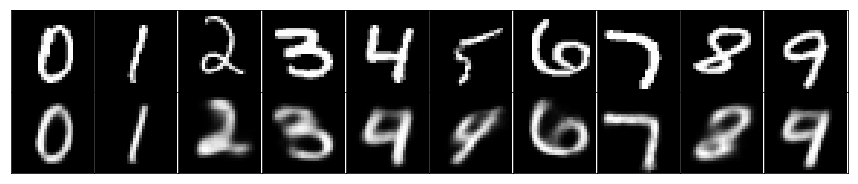

In [12]:
# Display input/output pairs
io_size, z_dim, eps_dim, hidden_size = 784, 4, 8, 512

images = {l: {'original': np.zeros((28,28)), 'reconstituted': np.zeros((28,28))} for l in range(10)}

found = [False for _ in range(10)]
for im, label in zip(mnist.test.images, mnist.test.labels):
    l = np.int(np.squeeze(np.where(label==1)))
    images[l]['original'] = np.reshape(im, (28, 28))
    found[l] = True
    if all(found):
        break

tf.reset_default_graph()
model = AVB(io_size, z_dim, eps_dim, hidden_size, build=False)

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('chck/avb.meta')
    saver.restore(sess, "chck/avb")
    with open('chck/avb_gc.pickle', 'rb') as f:
        gc = pickle.load(f) 
    model.init_from_graph(sess.graph, gc)    

    for l in range(10):
        img = np.reshape(images[l]['original'], 784)
        eps_batch = np.random.normal(0.0, 1.0, size=(1, model.eps_dim))        
        
        reconstituted = sess.run(model.reconstituted, 
                                 feed_dict={model.input: img[np.newaxis,:], model.eps: eps_batch})
        images[l]['reconstituted'] = np.reshape(reconstituted, (28, 28))

fig, axes = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(1.5*10,2*1.5))
for ii in range(10):
    axes[0][ii].imshow(images[ii]['original'], aspect='equal', cmap='gray')
    axes[0][ii].xaxis.set_visible(False)
    axes[0][ii].yaxis.set_visible(False)
    axes[1][ii].imshow(images[ii]['reconstituted'], aspect='equal', cmap='gray')
    axes[1][ii].xaxis.set_visible(False)
    axes[1][ii].yaxis.set_visible(False)
    
plt.subplots_adjust(wspace=0, hspace=0)

INFO:tensorflow:Restoring parameters from chck/avb


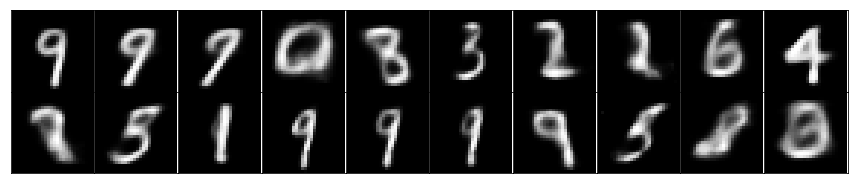

In [21]:
# Generate some samples
io_size, z_dim, eps_dim, hidden_size = 784, 4, 8, 512
hsamples, vsamples = 10, 2

tf.reset_default_graph()
model = AVB(io_size, z_dim, eps_dim, hidden_size, build=False)

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('chck/avb.meta')
    saver.restore(sess, "chck/avb")
    with open('chck/avb_gc.pickle', 'rb') as f:
        gc = pickle.load(f) 
    model.init_from_graph(sess.graph, gc)   

    #z_batch = np.random.normal(0.0, 1.0, size=(batch_size, model.z_dim))
    z_batch = np.random.uniform(-3.0, 3.0, size=(batch_size, model.z_dim))
    
    samples = sess.run(model.samples, 
                       feed_dict={model.z_input: z_batch})
 
fig, axes = plt.subplots(vsamples, hsamples, sharex=True, sharey=True, figsize=(1.5*hsamples,1.5*vsamples))
for ih in range(hsamples):
    for iv in range(vsamples):
        img = np.reshape(samples[ih+iv*hsamples,:], (28, 28))
        axes[iv][ih].imshow(img, aspect='equal', cmap='gray')
        axes[iv][ih].xaxis.set_visible(False)
        axes[iv][ih].yaxis.set_visible(False)
        
plt.subplots_adjust(wspace=0, hspace=0)        